<a href="https://colab.research.google.com/github/KelseyWang2022/Evaluation-algorithm-of-bus-route/blob/main/Wasserstein_GAN(10_7).ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
import pandas as pd
import numpy as np
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader, TensorDataset
from sklearn.preprocessing import StandardScaler
import os

# 设置随机种子以确保结果可重复
torch.manual_seed(42)
np.random.seed(42)

# 检查GPU是否可用
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"Using device: {device}")

# 1. 导入数据集
file_path = '/content/cleaned_data_final.csv'

if not os.path.exists(file_path):
    raise FileNotFoundError(f"文件路径 {file_path} 不存在。请检查路径是否正确。")

data = pd.read_csv(file_path)

# 2. 识别特征类型
categorical_columns = ['lum', 'agg', 'int', 'atm', 'col', 'an', 'season', 'week',
                      'peak', 'nbv', 'catr', 'circ', 'vosp', 'prof', 'plan', 'surf',
                      'infra', 'situ', 'senc', 'occutc', 'obs', 'obsm', 'choc', 'manv',
                      'sexe', 'trajet', 'secu', 'year']
integer_columns = ['age']
# 记录每个分类变量的可能取值
category_values = {col: sorted(data[col].unique()) for col in categorical_columns}

# 3. 合并类别0和3为"severe/death"
data['grav_balanced'] = data['grav'].replace({0: 3, 3: 3})

# 4. 数据预处理
numeric_columns = data.select_dtypes(include=[np.number]).columns.tolist()
if 'grav' in numeric_columns:
    numeric_columns.remove('grav')
if 'grav_balanced' in numeric_columns:
    numeric_columns.remove('grav_balanced')

features = data[numeric_columns]
scaler = StandardScaler()
scaled_features = scaler.fit_transform(features)

# 将特征转化为PyTorch tensor
X = torch.tensor(scaled_features, dtype=torch.float32).to(device)
y = torch.tensor(data['grav_balanced'].values, dtype=torch.float32).to(device)

dataset = TensorDataset(X, y)
dataloader = DataLoader(dataset, batch_size=64, shuffle=True)

# 5. 定义改进的WGAN模型
class Generator(nn.Module):
    def __init__(self, input_dim, output_dim):
        super(Generator, self).__init__()
        self.model = nn.Sequential(
            nn.Linear(input_dim, 256),
            nn.BatchNorm1d(256),
            nn.LeakyReLU(0.2),
            nn.Linear(256, 512),
            nn.BatchNorm1d(512),
            nn.LeakyReLU(0.2),
            nn.Linear(512, 256),
            nn.BatchNorm1d(256),
            nn.LeakyReLU(0.2),
            nn.Linear(256, output_dim),
            nn.Tanh()  # 使用Tanh确保输出在合理范围内
        )

    def forward(self, z):
        return self.model(z)

class Discriminator(nn.Module):
    def __init__(self, input_dim):
        super(Discriminator, self).__init__()
        self.model = nn.Sequential(
            nn.Linear(input_dim, 256),
            nn.LeakyReLU(0.2),
            nn.Linear(256, 512),
            nn.LeakyReLU(0.2),
            nn.Linear(512, 256),
            nn.LeakyReLU(0.2),
            nn.Linear(256, 1)
        )

    def forward(self, x):
        return self.model(x)

# 6. 初始化模型
generator = Generator(100, X.shape[1]).to(device)
discriminator = Discriminator(X.shape[1]).to(device)

# 7. 训练参数设置
z_dim = 100
lr = 1e-5
n_epochs = 1000
n_critic = 5
clip_value = 0.01

optimizer_G = optim.RMSprop(generator.parameters(), lr=lr)
optimizer_D = optim.RMSprop(discriminator.parameters(), lr=lr)

# 8. 训练循环
for epoch in range(1, n_epochs + 1):
    for i, (real_data, _) in enumerate(dataloader):
        batch_size = real_data.size(0)
        real_data = real_data.to(device)

        # 训练判别器
        for _ in range(n_critic):
            optimizer_D.zero_grad()
            real_output = discriminator(real_data)
            real_loss = -torch.mean(real_output)

            z = torch.randn(batch_size, z_dim).to(device)
            fake_data = generator(z)
            fake_output = discriminator(fake_data.detach())
            fake_loss = torch.mean(fake_output)

            d_loss = real_loss + fake_loss
            d_loss.backward()
            optimizer_D.step()

            for p in discriminator.parameters():
                p.data.clamp_(-clip_value, clip_value)

        # 训练生成器
        optimizer_G.zero_grad()
        z = torch.randn(batch_size, z_dim).to(device)
        fake_data = generator(z)
        fake_output = discriminator(fake_data)
        g_loss = -torch.mean(fake_output)
        g_loss.backward()
        optimizer_G.step()

    if epoch % 100 == 0:
        print(f"Epoch [{epoch}/{n_epochs}] | D Loss: {d_loss.item():.4f} | G Loss: {g_loss.item():.4f}")

# 9. 生成和后处理合成数据
desired_samples = max(data['grav_balanced'].value_counts().drop(3).values) - data['grav_balanced'].value_counts()[3]
n_synthetic = int(desired_samples)

z = torch.randn(n_synthetic, z_dim).to(device)
with torch.no_grad():
    synthetic_data = generator(z).cpu().numpy()

# 还原到原始特征的比例
synthetic_data_original_scale = scaler.inverse_transform(synthetic_data)
synthetic_df = pd.DataFrame(synthetic_data_original_scale, columns=numeric_columns)

# 10. 后处理特征以确保符合原始分布
for col in categorical_columns:
    # 对于分类特征，从原始数据的唯一值中随机选择
    synthetic_df[col] = np.random.choice(category_values[col], size=n_synthetic)

for col in integer_columns:
    # 对于整数特征，四舍五入到最近的整数，并确保在原始数据的范围内
    min_val = int(data[col].min())
    max_val = int(data[col].max())
    synthetic_df[col] = np.clip(np.round(synthetic_df[col]), min_val, max_val)

# 添加目标变量
synthetic_df['grav_balanced'] = 3

# 11. 合并数据并保存
balanced_data = pd.concat([data, synthetic_df], ignore_index=True)
balanced_data.to_csv('balanced_accidents_dataset.csv', index=False)
print("\n平衡后的数据集已保存为 'balanced_accidents_dataset.csv'")

# 12. 验证生成的数据
def verify_data_distribution(original_data, generated_data):
    print("\n数据验证报告:")
    for col in original_data.columns:
        if col in categorical_columns:
            print(f"\n{col} 的分布验证:")
            print("原始数据取值:", sorted(original_data[col].unique()))
            print("生成数据取值:", sorted(generated_data[col].unique()))
        elif col in integer_columns:
            print(f"\n{col} 的范围验证:")
            print(f"原始数据范围: [{original_data[col].min()}, {original_data[col].max()}]")
            print(f"生成数据范围: [{generated_data[col].min()}, {generated_data[col].max()}]")

# 验证生成的数据
verify_data_distribution(data, synthetic_df)

Using device: cuda
Epoch [100/1000] | D Loss: -0.0367 | G Loss: -0.0417
Epoch [200/1000] | D Loss: -0.0479 | G Loss: 0.0391
Epoch [300/1000] | D Loss: -0.0578 | G Loss: 0.0396
Epoch [400/1000] | D Loss: -0.0522 | G Loss: 0.0389
Epoch [500/1000] | D Loss: -0.0456 | G Loss: 0.0387
Epoch [600/1000] | D Loss: -0.0284 | G Loss: 0.0360
Epoch [700/1000] | D Loss: -0.0547 | G Loss: 0.0354
Epoch [800/1000] | D Loss: -0.0369 | G Loss: 0.0359
Epoch [900/1000] | D Loss: -0.0536 | G Loss: 0.0326
Epoch [1000/1000] | D Loss: -0.0344 | G Loss: 0.0356

平衡后的数据集已保存为 'balanced_accidents_dataset.csv'

数据验证报告:

an 的分布验证:
原始数据取值: [14, 15, 16, 17, 18]
生成数据取值: [14, 15, 16, 17, 18]

lum 的分布验证:
原始数据取值: [1, 2, 3, 4, 5]
生成数据取值: [1, 2, 3, 4, 5]

agg 的分布验证:
原始数据取值: [1, 2]
生成数据取值: [1, 2]

int 的分布验证:
原始数据取值: [1, 2, 3, 4, 5, 6, 7, 8, 9]
生成数据取值: [1, 2, 3, 4, 5, 6, 7, 8, 9]

atm 的分布验证:
原始数据取值: [1.0, 2.0, 3.0, 4.0, 5.0, 6.0, 7.0, 8.0, 9.0]
生成数据取值: [1.0, 2.0, 3.0, 4.0, 5.0, 6.0, 7.0, 8.0, 9.0]

col 的分布验证:
原始数据取值: [1.0, 2.0

In [2]:

data_2 = pd.read_csv('/content/balanced_accidents_dataset.csv')


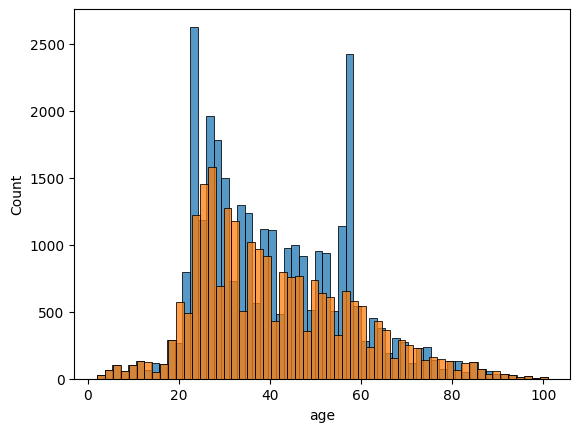

In [6]:
#可视化显示age的分布

import seaborn as sns
import matplotlib.pyplot as plt
#查看特征列名

#统计年龄的分布
sns.histplot(data_2['age'])
sns.histplot(data['age'])


plt.show()





In [7]:
#可视化损失函数

# 绘制损失曲线
plt.figure(figsize=(12, 6))
plt.plot(epoch_losses_d, label='Discriminator Loss', alpha=0.5)
plt.plot(epoch_losses_g, label='Generator Loss', alpha=0.5)
plt.title('WGAN Training Loss Over Time')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.grid(True, alpha=0.3)

# 添加平滑曲线
window_size = 50
if len(epoch_losses_d) > window_size:
    d_smooth = pd.Series(epoch_losses_d).rolling(window=window_size).mean()
    g_smooth = pd.Series(epoch_losses_g).rolling(window=window_size).mean()
    plt.plot(d_smooth, label='Discriminator Loss (Smoothed)', linestyle='--')
    plt.plot(g_smooth, label='Generator Loss (Smoothed)', linestyle='--')
    plt.legend()

plt.tight_layout()
plt.show()

# 保存损失图
plt.savefig('wgan_loss.png')
print("\n损失曲线已保存为 'wgan_loss.png'")


NameError: name 'epoch_losses_d' is not defined

<Figure size 1200x600 with 0 Axes>